In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from imblearn.under_sampling import RandomUnderSampler
import random
random.seed(42)

In [2]:
websites=["akakce","amazon","arabam","donanimhaber","haberturk","mgm","nefisyemektarifleri","pazarama","trendyol"]

datas=[]
for website in websites:
    data=pd.read_csv(website+"_paired.csv",encoding='latin1')
    # Perform random under sampling
    rus = RandomUnderSampler(random_state=42)
    data_rus, _ = rus.fit_resample(data, data["identical"])
    data_rus.reset_index(inplace=True)
    print(website,data_rus.shape)
    datas.append(data_rus)
data=pd.concat(datas,ignore_index=True).drop("index",axis=1)
print(data.shape)
data.head()

akakce (2694, 7)
amazon (1374, 7)
arabam (2824, 7)
donanimhaber (754, 7)
haberturk (24000, 7)
mgm (570, 7)
nefisyemektarifleri (756, 7)
pazarama (4104, 7)
trendyol (5402, 7)
(42478, 6)


,url1,url2,url1_dir,url2_dir,pair,identical
0,https://www.akakce.com/elektrikli-bisiklet/iki...,https://www.akakce.com/info/hakkimizda.asp,www.akakce.com/67,www.akakce.com/83,searchhak,False
1,https://www.akakce.com/cocuk-giyim-aksesuar.html,https://www.akakce.com/info/hakkimizda.asp,www.akakce.com/75,www.akakce.com/83,serach1hak,False
2,https://www.akakce.com/televizyon/en-ucuz-sams...,https://www.akakce.com/magaza/vivensecom.html,www.akakce.com/31,www.akakce.com/74,itemstore,False
3,https://www.akakce.com/elektrikli-bisiklet/en-...,https://www.akakce.com/magaza/ciceksepeti.html,www.akakce.com/39,www.akakce.com/73,itemstore,False
4,https://www.akakce.com/saat-giyim-aksesuar.html,https://www.akakce.com/en-cok-takip-edilen-uru...,www.akakce.com/76,www.akakce.com/87,serach1kam,False


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model

# Input shapes
input_shape = (256, 256, 3)

# Define two input layers
input_1 = Input(shape=input_shape, name='input_1')
input_2 = Input(shape=input_shape, name='input_2')

# Option 1: Share the same ResNet model (shared weights)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze the base model (optional, for feature extraction)
base_model.trainable = True

# Apply the same model to both inputs
features_1 = base_model(input_1)
features_2 = base_model(input_2)

# Option 2: Use separate ResNet models (unshared weights)
# base_model_1 = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
# base_model_2 = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
# base_model_1.trainable = False
# base_model_2.trainable = False
# features_1 = base_model_1(input_1)
# features_2 = base_model_2(input_2)

# Pool the features
pool_1 = GlobalAveragePooling2D()(features_1)
pool_2 = GlobalAveragePooling2D()(features_2)

# Combine features
combined = Concatenate()([pool_1, pool_2])

# Classification head
x = Dense(2048, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(x) # Binary classification

# Create model
model = Model(inputs=[input_1, input_2], outputs=output)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3,decay=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 8, 8, 2048)   23587712    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [4]:
def load_and_preprocess_image(path, img_size=(256, 256)):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)  # use decode_png for PNGs
    image = tf.image.resize(image, img_size)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # normalize for ResNet
    return image

def make_dataset(image_paths_1, image_paths_2, labels, batch_size=32, shuffle=True):
    path_ds_1 = tf.data.Dataset.from_tensor_slices(image_paths_1)
    path_ds_2 = tf.data.Dataset.from_tensor_slices(image_paths_2)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)

    def process_pair(path1, path2, label):
        img1 = load_and_preprocess_image("data/"+path1+"/ss.png")
        img2 = load_and_preprocess_image("data/"+path2+"/ss.png")
        return {'input_1': img1, 'input_2': img2}, label

    dataset = tf.data.Dataset.zip((path_ds_1, path_ds_2, label_ds))
    dataset = dataset.map(process_pair, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(labels))

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

from sklearn.model_selection import train_test_split

train_img1, test_img1, train_img2, test_img2, train_labels, test_labels = train_test_split(
    data["url1_dir"].to_numpy(), data["url2_dir"].to_numpy(), data["identical"].to_numpy(),
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
train_img1, val_img1, train_img2, val_img2, train_labels, val_labels = train_test_split(
    train_img1, train_img2, train_labels,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
train_dataset = make_dataset(train_img1, train_img2, train_labels, batch_size=32, shuffle=False)
val_dataset = make_dataset(val_img1, val_img2, val_labels, batch_size=32, shuffle=False)
test_dataset = make_dataset(test_img1, test_img2, test_labels, batch_size=32, shuffle=False)
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=30, verbose=1)

Epoch 1/30
850/850 [==============================] - 575s 660ms/step - loss: 0.2731 - accuracy: 0.8839 - val_loss: 0.2948 - val_accuracy: 0.9229
Epoch 2/30
850/850 [==============================] - 561s 660ms/step - loss: 0.0919 - accuracy: 0.9653 - val_loss: 0.2235 - val_accuracy: 0.9079
Epoch 3/30
850/850 [==============================] - 559s 658ms/step - loss: 0.0518 - accuracy: 0.9812 - val_loss: 0.0493 - val_accuracy: 0.9841
Epoch 4/30
850/850 [==============================] - 567s 667ms/step - loss: 0.0325 - accuracy: 0.9894 - val_loss: 0.0342 - val_accuracy: 0.9903
Epoch 5/30
850/850 [==============================] - 557s 655ms/step - loss: 0.0288 - accuracy: 0.9905 - val_loss: 0.0358 - val_accuracy: 0.9860
Epoch 6/30
850/850 [==============================] - 558s 657ms/step - loss: 0.0184 - accuracy: 0.9942 - val_loss: 0.0188 - val_accuracy: 0.9938
Epoch 7/30
850/850 [==============================] - 560s 659ms/step - loss: 0.0176 - accuracy: 0.9940 - val_loss: 0.0197 -

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


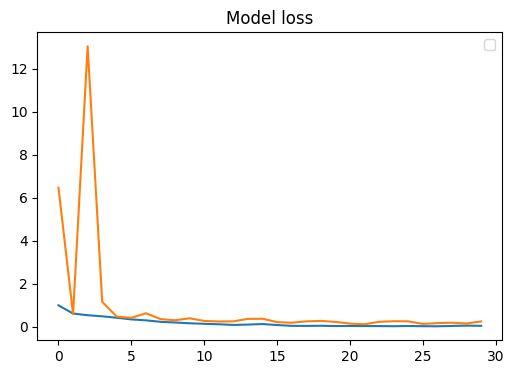

In [8]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6, 4))
plt.legend()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model loss')
plt.show()

In [5]:
model.evaluate(test_dataset, verbose=1)

266/266 [==============================] - 41s 153ms/step - loss: 0.0042 - accuracy: 0.9984


[0.00424534734338522, 0.9983521699905396]

In [6]:
model.evaluate(test_dataset, verbose=1)
model.save("models/resnet50.h5")

21/21 [==============================] - 3s 156ms/step - loss: 0.2906 - accuracy: 0.9398


In [ ]:
from tensorflow.keras.layers import Dropout, BatchNormalization, Flatten, Conv2D

# Load pre-trained MobileNetV2 model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Hyperparameter tuning
learning_rates = [1e-4, 1e-3]
batch_sizes = [16, 32]
dropout_rates = [0.3, 0.5]
dense_units = [128, 256]  # Different dense layer sizes
best_model = None
best_accuracy = 0

for lr in learning_rates:
    for batch_size in batch_sizes:
        for dropout_rate in dropout_rates:
            for units in dense_units:
                print(f"Training with learning rate: {lr}, batch size: {batch_size}, dropout rate: {dropout_rate}, dense units: {units}")
                
                # Modify the head layers dynamically
                x = base_model.output
                x = GlobalAveragePooling2D()(x)
                x = Dense(units, activation='relu')(x)
                x = BatchNormalization()(x)
                x = Dropout(dropout_rate)(x)
                x = Dense(units // 2, activation='relu')(x)  # Add another dense layer
                x = Dropout(dropout_rate)(x)
                predictions = Dense(len(np.unique(y)), activation='softmax')(x)
                model = Model(inputs=base_model.input, outputs=predictions)
                
                # Compile the model
                model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                
                # Early stopping
                early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
                
                # Train the model
                history = model.fit(
                    datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_val, y_val),
                    epochs=10,
                    callbacks=[early_stopping],
                    verbose=1
                )
                
                # Evaluate the model
                val_accuracy = max(history.history['val_accuracy'])
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_model = model

# Evaluate the best model
y_pred = np.argmax(best_model.predict(X_val), axis=1)
print(classification_report(y_val, y_pred))
